In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [ ]:
# ori_df = pd.read_parquet('/home/l.morales/.kiauhoku/grids/yrec/yrec_eep.pqt')
# ori_df['teff'] = 10 ** ori_df['Log Teff(K)']
# ori_df['age'] = ori_df['Age(Gyr)'] 
# ori_df = ori_df.reset_index()

# X = ori_df[['initial_mass','initial_met','logg']].copy()
# Y = ori_df[['age','teff']]

# X.columns = ['mass','met','logg']

In [26]:
# Load and unpack index (includes EEP, mass, metallicity)
ori_df = pd.read_parquet('/home/l.morales/.kiauhoku/grids/yrec/yrec_eep.pqt')
ori_df = ori_df.reset_index()  # Brings EEP and other index levels into columns

# Compute useful columns
ori_df['teff'] = 10 ** ori_df['Log Teff(K)']
ori_df['age'] = np.log10(ori_df['Age(Gyr)']) 

# 🔪 Apply EEP cut to isolate RGB
# You can adjust this range depending on your tracks — 500–800 is a typical RGB slice
rgb_df = ori_df[(ori_df['eep'] >= 450) & (ori_df['eep'] <= 951)]

# Now extract X and Y from the *filtered* DataFrame
X = rgb_df[['initial_mass', 'initial_met', 'logg']].copy()
Y = rgb_df[['age', 'teff']]

# Rename X columns for consistency
X.columns = ['mass', 'met', 'logg']

Scaling age and teff

In [27]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.values)
Y_scaled = scaler_Y.fit_transform(Y.values)

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=0)

Epoch 1/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5107 - val_loss: 0.1287
Epoch 2/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1245 - val_loss: 0.1132
Epoch 3/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0992 - val_loss: 0.0992
Epoch 4/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0866 - val_loss: 0.0889
Epoch 5/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0776 - val_loss: 0.0800
Epoch 6/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0724 - val_loss: 0.0740
Epoch 7/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0682 - val_loss: 0.0692
Epoch 8/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0622 - val_loss: 0.0653
Epoch 9/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0634 - val_loss: 0.0626
Epoch 10/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0603 - val_loss: 0.0599
Epoch 11/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0530 - val_loss: 0.0577
Epoch 12/1000
334/334 ━━━━━━━━

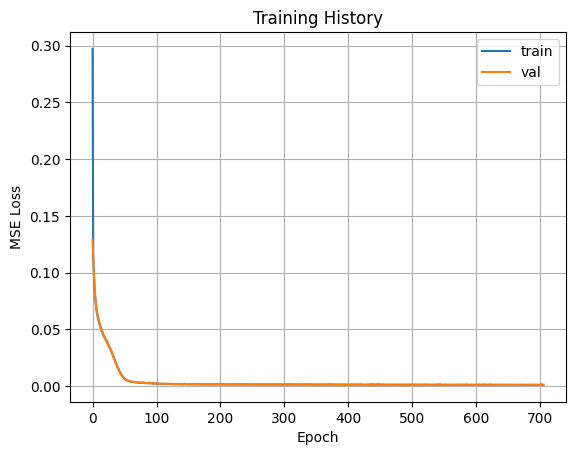

In [28]:
def build_ann():
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))  # mass, met, logg
    for _ in range(6):
        model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(2))  # Outputs: age, teff
    return model

model = build_ann()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='mse')

#Optional: Save the best version
checkpoint_cb = ModelCheckpoint("best_ann_model.keras", save_best_only=True)

# Stop training if val_loss doesn't improve after 50 epochs
earlystop_cb = EarlyStopping(patience=50, restore_best_weights=True)

# Now train with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_cb, earlystop_cb]
)
# --- Plot training history ---
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

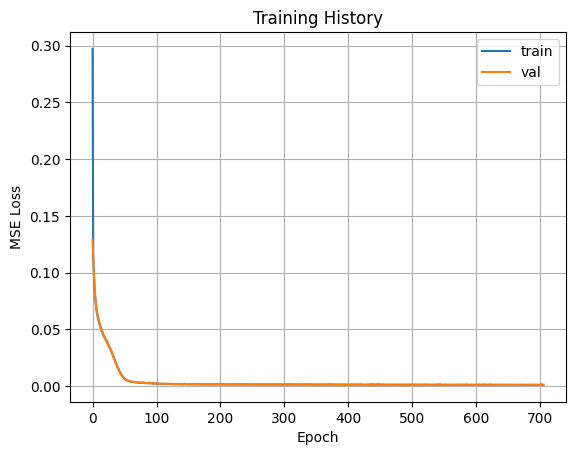

In [29]:
# --- Plot training history ---
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Grab final val loss
val_loss_std_units = history.history['val_loss'][-1]
val_rmse_std = np.sqrt(val_loss_std_units)

# Get std from scaler (for log(age) and Teff)
logage_std = np.sqrt(scaler_Y.var_[0])
teff_std = np.sqrt(scaler_Y.var_[1])

# Translate into physical units
logage_rmse = val_rmse_std * logage_std
teff_rmse = val_rmse_std * teff_std

print(f"RMSE in log(age): {logage_rmse:.4f} dex")
print(f"RMSE in Teff: {teff_rmse:.1f} K")

# Optional: convert log(age) RMSE to % age error
age_factor = 10 ** logage_rmse
print(f"Multiplicative age error factor: x{age_factor:.3f}")


RMSE in log(age): 0.0169 dex
RMSE in Teff: 29.5 K
Multiplicative age error factor: x1.040


In [31]:
# Evaluate loss in standardized units
val_loss = model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation MSE (std units): {val_loss:.6f}")


Validation MSE (std units): 0.000933


By training an artificial neural network to emulate YREC stellar model grids, I found that the predictive precision asymptotically approached the resolution of the original grid itself. This revealed a fundamental, often unacknowledged uncertainty floor: even in the absence of observational noise, interpolated ages from these grids carry a theoretical uncertainty set by the spacing in mass, metallicity, and evolutionary phase.

In [40]:
colnames = ['KEPLER_ID','initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age','flag']
df_subset = pd.read_csv("/home/l.morales/ML_ages/seis_yrec.csv",header=None,names=colnames)  
X_test = df_subset[['mass', 'met', 'logg']].copy()
X_test_clean = X_test[df_subset['flag'] == 0].copy()

X_test_scaled = scaler_X.transform(X_test_clean)

/home/l.morales/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [42]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_Y.inverse_transform(predictions_scaled)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


In [45]:
df_clean = df_subset[df_subset['flag'] == 0].copy()
df_clean['log_age_pred'] = predictions[:, 0]
df_clean['teff_pred'] = predictions[:, 1]
df_clean['age_pred'] = 10 ** df_clean['log_age_pred']



In [49]:
df_clean['age_offset'] = df_clean['age_pred'] - df_clean['age']
df_clean['frac_offset'] = df_clean['age_offset'] / df_clean['age']

In [50]:
df_clean

,KEPLER_ID,initial_mass,initial_met,eep,mass,teff,lum,met,logg,age,flag,log_age_pred,teff_pred,age_pred,age_offset,frac_offset
0,10000162,1.074200,0.103644,517.798619,1.074200,4749.006787,12.317625,0.103644,3.048499,9.895512,0,0.994784,4748.910645,9.880608,-0.014904,-0.001506
1,10000198,1.110199,-0.117824,524.990749,1.110199,4834.909429,14.735282,-0.117824,3.007999,7.666292,0,0.888140,4834.357910,7.729299,0.063007,0.008219
2,10000207,1.053999,-0.082414,525.908625,1.053999,4753.679694,17.379800,-0.082414,2.883899,9.683272,0,0.981027,4753.190430,9.572545,-0.110726,-0.011435
3,10000547,1.139699,-0.211104,524.085150,1.139699,4928.971722,12.603123,-0.211104,3.122099,6.597732,0,0.818645,4927.591309,6.586353,-0.011379,-0.001725
4,10001326,1.217400,-0.069832,546.660714,1.217400,4648.976242,36.728661,-0.069832,2.581700,5.798055,0,0.760017,4648.435059,5.754623,-0.043432,-0.007491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,9994845,1.286400,0.009462,558.858830,1.286400,4549.549675,52.180059,0.009462,2.415400,5.012776,0,0.696466,4547.649902,4.971258,-0.041518,-0.008282
4335,9995133,1.028101,-0.127669,538.278461,1.028101,4656.150549,28.910963,-0.127669,2.614200,10.325821,0,1.008023,4648.970215,10.186448,-0.139373,-0.013498
4336,9995162,1.160600,0.081878,539.144497,1.160600,4607.907023,29.661065,0.081878,2.642300,7.481684,0,0.870284,4607.671387,7.417949,-0.063735,-0.008519
4337,9996342,1.247300,0.193680,554.838966,1.247300,4459.247448,52.000013,0.193680,2.374300,6.124041,0,0.785237,4455.460938,6.098702,-0.025339,-0.004138


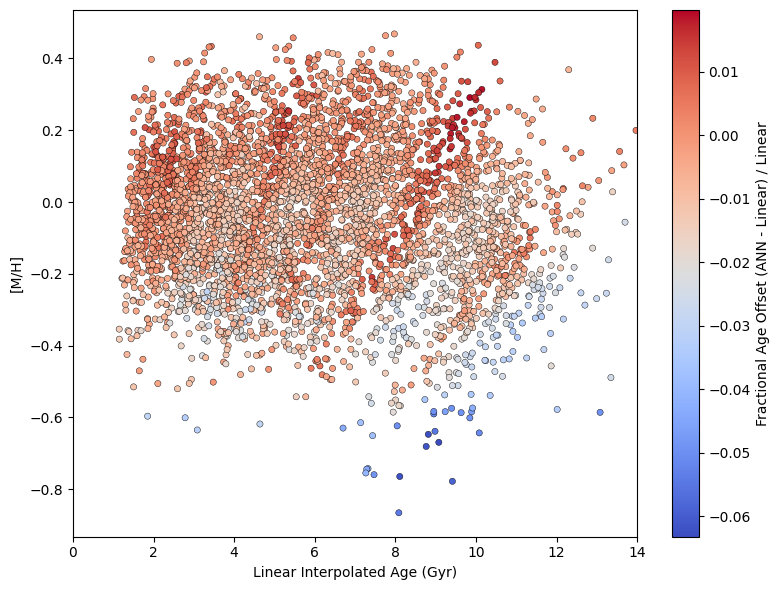

In [59]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['age_pred'], df_clean['met'], 
                 c=df_clean['frac_offset'], cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3)

plt.colorbar(sc, label='Fractional Age Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Age (Gyr)')
plt.ylabel('[M/H]')
plt.xlim(0,14)
plt.tight_layout()
plt.savefig('resultsANN.png')
plt.show()

In [57]:
mean_offset = df_clean['frac_offset'].mean()
std_offset = df_clean['frac_offset'].std()
print(f"Mean fractional offset: {mean_offset:.4f} ± {std_offset:.4f}")

Mean fractional offset: -0.0062 ± 0.0090
